In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

In [ ]:
'/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/processed/NA_Birds'

In [97]:
DATASET_ID = [
    "NA_BIRDS_american_crow",
    "NA_BIRDS_american_yellow_warbler",
    "NA_BIRDS_blue_jay",
    "NA_BIRDS_cedar_waxwing",
    "NA_BIRDS_chipping_sparrow",
    "NA_BIRDS_common_yellowthroat",
    "NA_BIRDS_great_blue_heron",
    "NA_BIRDS_house_finch",
    "NA_BIRDS_indigo_bunting",
    "NA_BIRDS_marsh_wren",
    "NA_BIRDS_song_sparrow",
]

In [98]:
from avgn.utils.hparams import HParams
from avgn.dataset import DataSet

In [99]:
from avgn.signalprocessing.create_spectrogram_dataset import prepare_wav, create_label_df, get_row_audio

### create dataset

In [162]:
hparams = HParams(
    num_mel_bins = 32,
    mel_lower_edge_hertz=250,
    mel_upper_edge_hertz=15999,
    butter_lowcut = 250,
    butter_highcut = 15999,
    ref_level_db = 20,
    min_level_db = -45,
    mask_spec = True,
    win_length_ms = 10,
    hop_length_ms = 2,
    mask_spec_kwargs = {"spec_thresh": 0.9, "offset": 1e-10}
)

In [163]:
# create a dataset object
dataset = DataSet(DATASET_ID, hparams = hparams)

In [164]:
dataset.sample_json

OrderedDict([('indvs',
              OrderedDict([('UNK',
                            OrderedDict([('syllables',
                                          OrderedDict([('start_times', [0]),
                                                       ('end_times',
                                                        [0.46503125])]))]))])),
             ('species', 'American crow'),
             ('common_name', 'Corvus brachyrhynchos'),
             ('wav_num', 243),
             ('wav_loc',
              '/mnt/cube/Datasets/NABirdSpecies/North American bird species/S4(American Crow)/s (243).wav'),
             ('samplerate_hz', 32000),
             ('length_s', 0.46503125)])

In [165]:
len(dataset.data_files)

2762

#### Create dataset based upon JSON

In [166]:
from joblib import Parallel, delayed
n_jobs = -1; verbosity = 10

In [167]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllable_dfs = parallel(
        delayed(create_label_df)(
            dataset.data_files[key].data,
            hparams=dataset.hparams,
            labels_to_retain=[],
            unit="syllables",
            dict_features_to_retain = ['species'],
            key = key,
        )
        for key in tqdm(dataset.data_files.keys())
    )
syllable_df = pd.concat(syllable_dfs)
len(syllable_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0234s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 832 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1104 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1408 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 1712 tasks      | elapsed:    2.9s


[Parallel(n_jobs=-1)]: Done 2762 out of 2762 | elapsed:    4.2s finished


2762

In [168]:
syllable_df[:3]

start_time  end_time indv  indvi        species                 key
0           0  0.465031  UNK      0  American crow  american_crow_0243
0           0  0.430031  UNK      0  American crow  american_crow_0208
0           0  0.405031  UNK      0  American crow  american_crow_0029

### get audio for dataset

In [169]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllable_dfs = parallel(
        delayed(get_row_audio)(
            syllable_df[syllable_df.key == key], 
            dataset.data_files[key].data['wav_loc'], 
            dataset.hparams
        )
        for key in tqdm(syllable_df.key.unique())
    )
syllable_df = pd.concat(syllable_dfs)
len(syllable_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:  

[Parallel(n_jobs=-1)]: Done 2762 out of 2762 | elapsed:   15.5s finished


2762

In [170]:
syllable_df[:3]

start_time  end_time indv  indvi        species                 key  \
0           0  0.465031  UNK      0  American crow  american_crow_0243   
0           0  0.430031  UNK      0  American crow  american_crow_0208   
0           0  0.405031  UNK      0  American crow  american_crow_0029   

                                               audio   rate  
0  [0.0030996066026771603, 0.002468325701773959, ...  32000  
0  [0.0004790301113228339, 0.0006568467900987811,...  32000  
0  [-0.0026205764913543265, -0.002008726604572815...  32000

In [171]:
syllable_df.indvi.values[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [172]:
sylls = syllable_df.audio.values

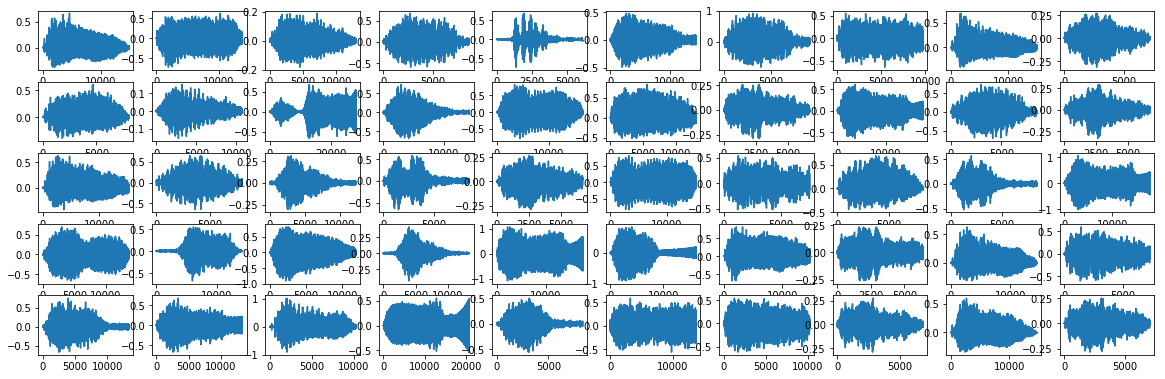

In [173]:
nrows = 5
ncols = 10
zoom = 2
fig, axs = plt.subplots(ncols=ncols, nrows = nrows,figsize = (ncols*zoom, nrows+zoom/1.5))
for i, syll in tqdm(enumerate(sylls), total = nrows*ncols):
    ax = axs.flatten()[i]
    ax.plot(syll)
    if i == nrows*ncols -1:
        break

### Create spectrograms

In [174]:
from avgn.visualization.spectrogram import draw_spec_set
from avgn.signalprocessing.create_spectrogram_dataset import make_spec, mask_spec, log_resize_spec, pad_spectrogram

In [175]:
syllables_wav = syllable_df.audio.values
syllables_rate = syllable_df.rate.values

In [176]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    # create spectrograms
    syllables_spec = parallel(
        delayed(make_spec)(
            syllable,
            rate,
            hparams=dataset.hparams,
            mel_matrix=dataset.mel_matrix,
            use_mel=True,
            use_tensorflow=False,
        )
        for syllable, rate in tqdm(
            zip(syllables_wav, syllables_rate),
            total=len(syllables_rate),
            desc="getting syllable spectrograms",
            leave=False,
        )
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0265s.) Setting batch_size=14.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1766s.) Setting batch_size=30.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 286 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 750 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1260 tasks      | elapsed:    0.9s


[Parallel(n_jobs=-1)]: Done 2762 out of 2762 | elapsed:    1.3s finished


### Rescale spectrogram
- using log rescaling

In [177]:
log_scaling_factor = 4

In [178]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllables_spec = parallel(
        delayed(log_resize_spec)(spec, scaling_factor=log_scaling_factor)
        for spec in tqdm(syllables_spec, desc="scaling spectrograms", leave=False)
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0121s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0121s.) Setting batch_size=1058.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


[Parallel(n_jobs=-1)]: Done 2762 out of 2762 | elapsed:    0.7s finished


(25.0, 10) (320, 800) 25.0 32 800


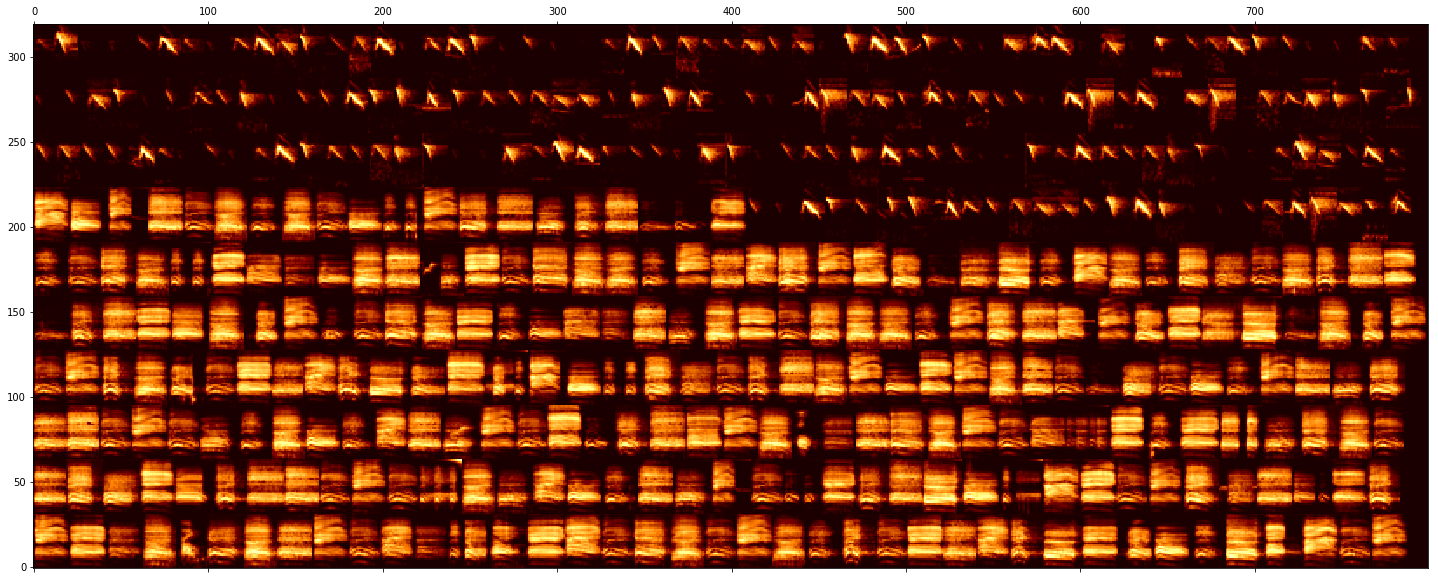

In [179]:
draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=25)

In [180]:
len(syllables_spec)

2762

### Pad spectrograms

In [181]:
syll_lens = [np.shape(i)[1] for i in syllables_spec]
pad_length = np.max(syll_lens)

In [182]:
syllable_df[:3]

start_time  end_time indv  indvi        species                 key  \
0           0  0.465031  UNK      0  American crow  american_crow_0243   
0           0  0.430031  UNK      0  American crow  american_crow_0208   
0           0  0.405031  UNK      0  American crow  american_crow_0029   

                                               audio   rate  
0  [0.0030996066026771603, 0.002468325701773959, ...  32000  
0  [0.0004790301113228339, 0.0006568467900987811,...  32000  
0  [-0.0026205764913543265, -0.002008726604572815...  32000

In [183]:
import seaborn as sns

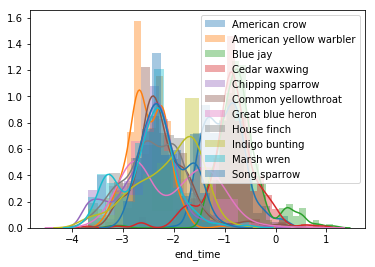

In [184]:
for species in np.unique(syllable_df.species):
    sns.distplot(np.log(syllable_df[syllable_df.species==species]["end_time"]), label=species)
plt.legend()

In [185]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:

    syllables_spec = parallel(
        delayed(pad_spectrogram)(spec, pad_length)
        for spec in tqdm(
            syllables_spec, desc="padding spectrograms", leave=False
        )
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0123s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1509s.) Setting batch_size=84.
[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:    0.2s


[Parallel(n_jobs=-1)]: Done 2762 out of 2762 | elapsed:    0.4s finished


(25.0, 10) (320, 800) 25.0 32 800


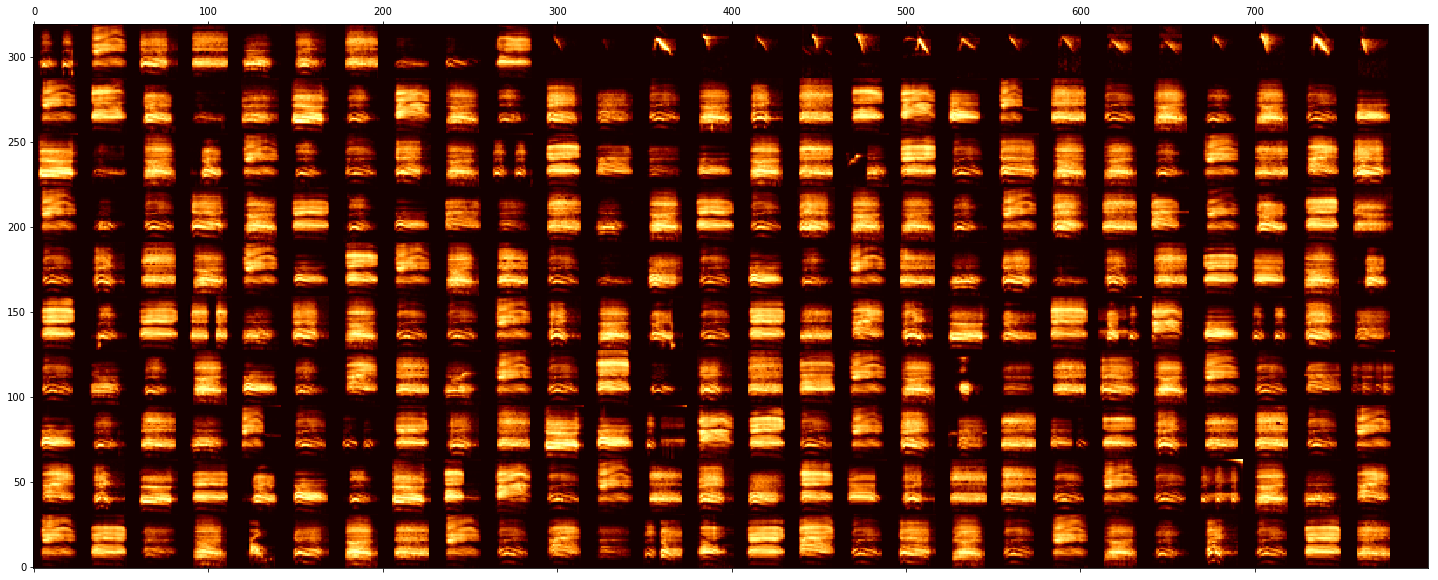

In [186]:
draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=25)

In [187]:
np.shape(syllables_spec)

(2762, 32, 29)

In [188]:
syllable_df['spectrogram'] = syllables_spec

In [189]:
syllable_df[:3]

start_time  end_time indv  indvi        species                 key  \
0           0  0.465031  UNK      0  American crow  american_crow_0243   
0           0  0.430031  UNK      0  American crow  american_crow_0208   
0           0  0.405031  UNK      0  American crow  american_crow_0029   

                                               audio   rate  \
0  [0.0030996066026771603, 0.002468325701773959, ...  32000   
0  [0.0004790301113228339, 0.0006568467900987811,...  32000   
0  [-0.0026205764913543265, -0.002008726604572815...  32000   

                                         spectrogram  
0  [[0.0, 0.0, 0.0, 0.0, -0.0002469581, 0.0016932...  
0  [[0.0, 0.0, 0.0, 0.0, 0.0007178107, 0.00301318...  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...

### view syllables per indv

In [190]:
syllable_df.species.unique()

array(['American crow', 'American yellow warbler', 'Blue jay',
       'Cedar waxwing', 'Chipping sparrow', 'Common yellowthroat',
       'Great blue heron', 'House finch', 'Indigo bunting', 'Marsh wren',
       'Song sparrow'], dtype=object)

American crow 253
(50.0, 20) (320, 800) 25.0 32 800


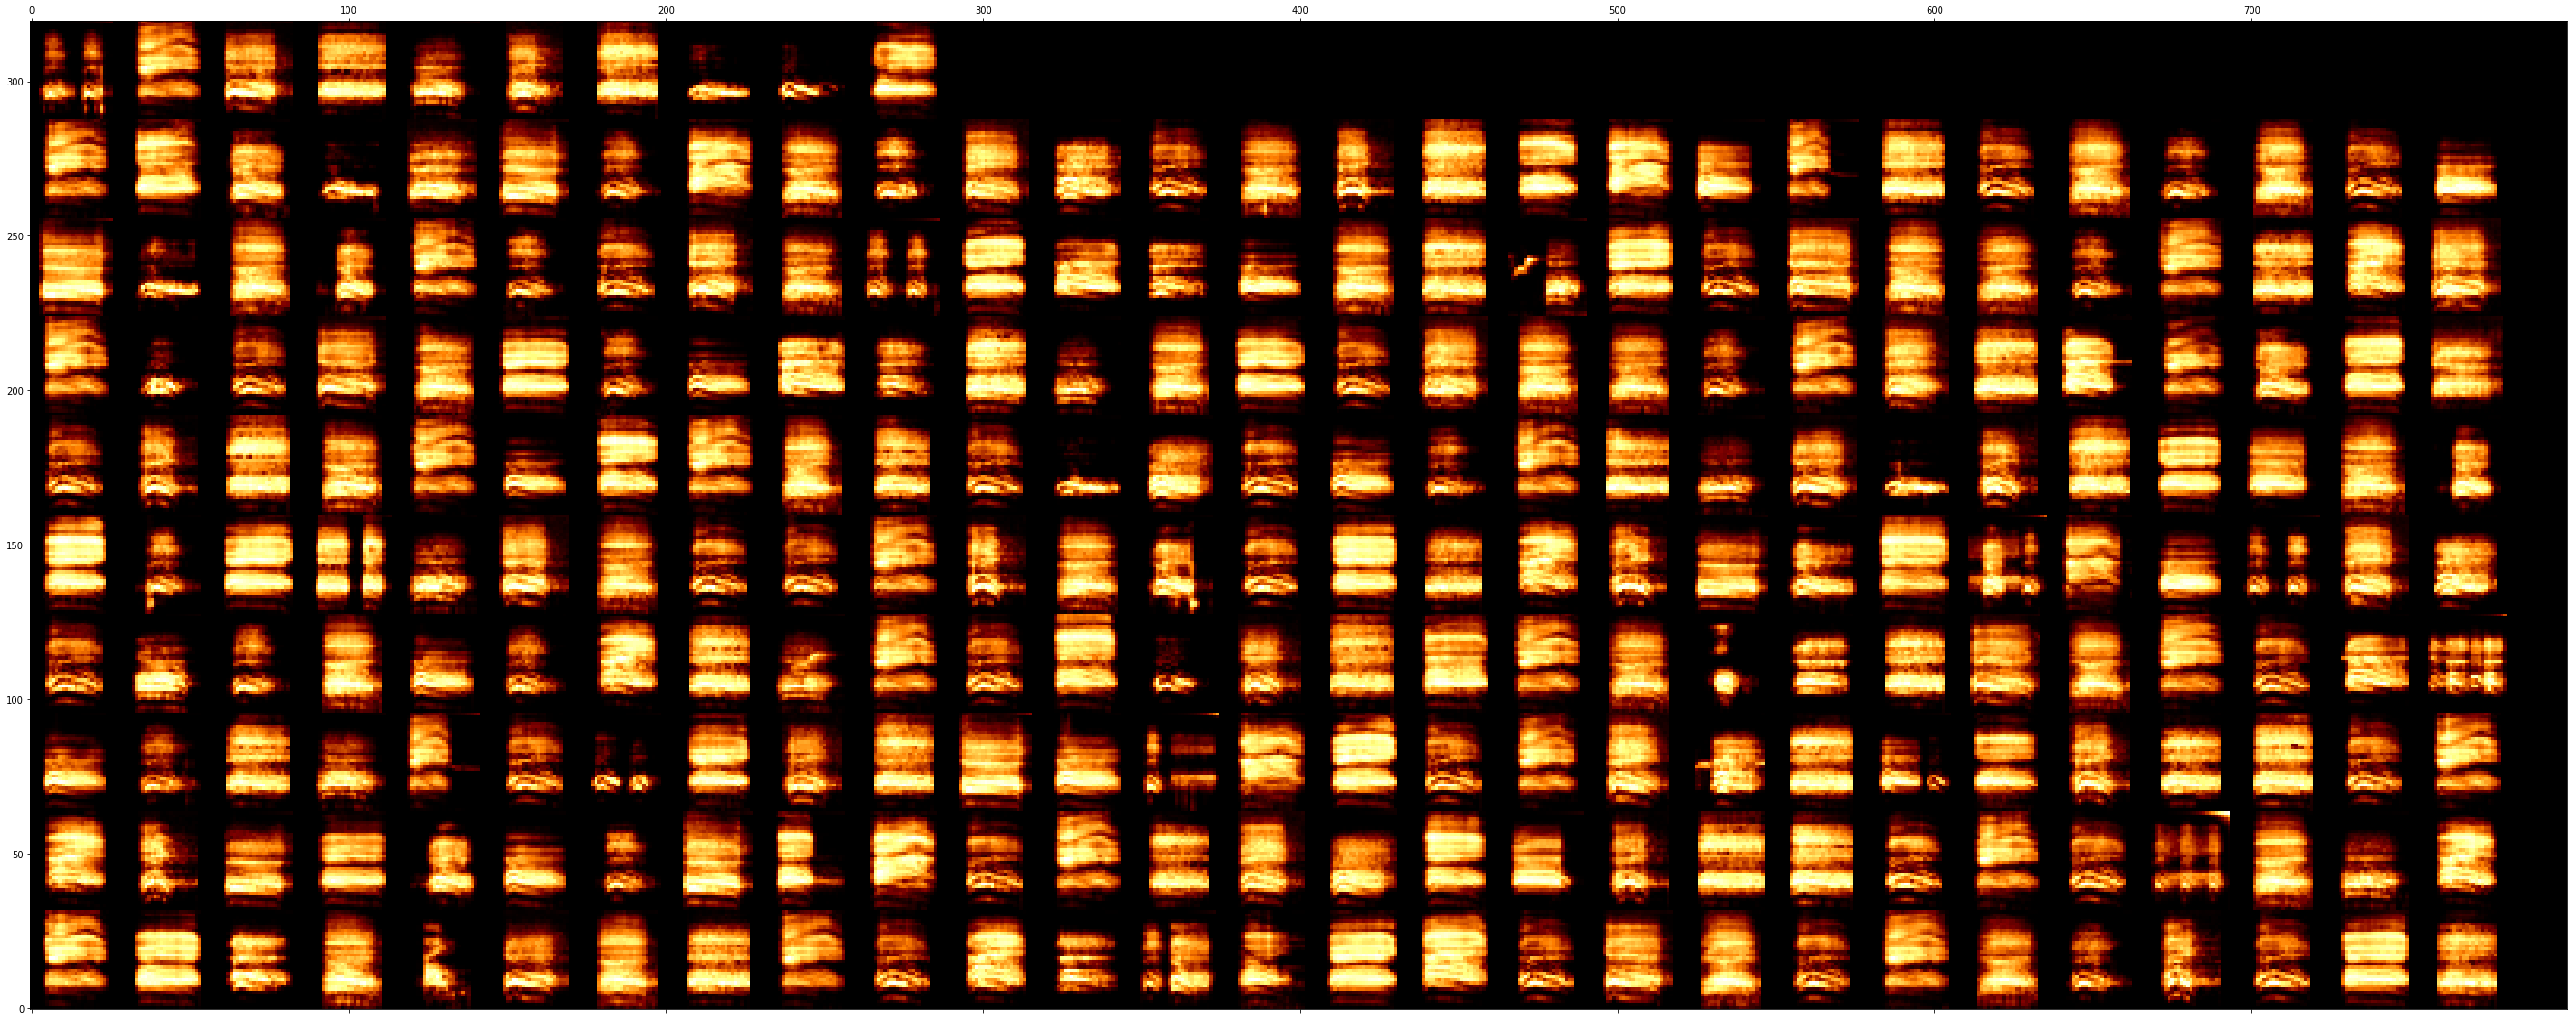

American yellow warbler 247
(50.0, 20) (320, 800) 25.0 32 800


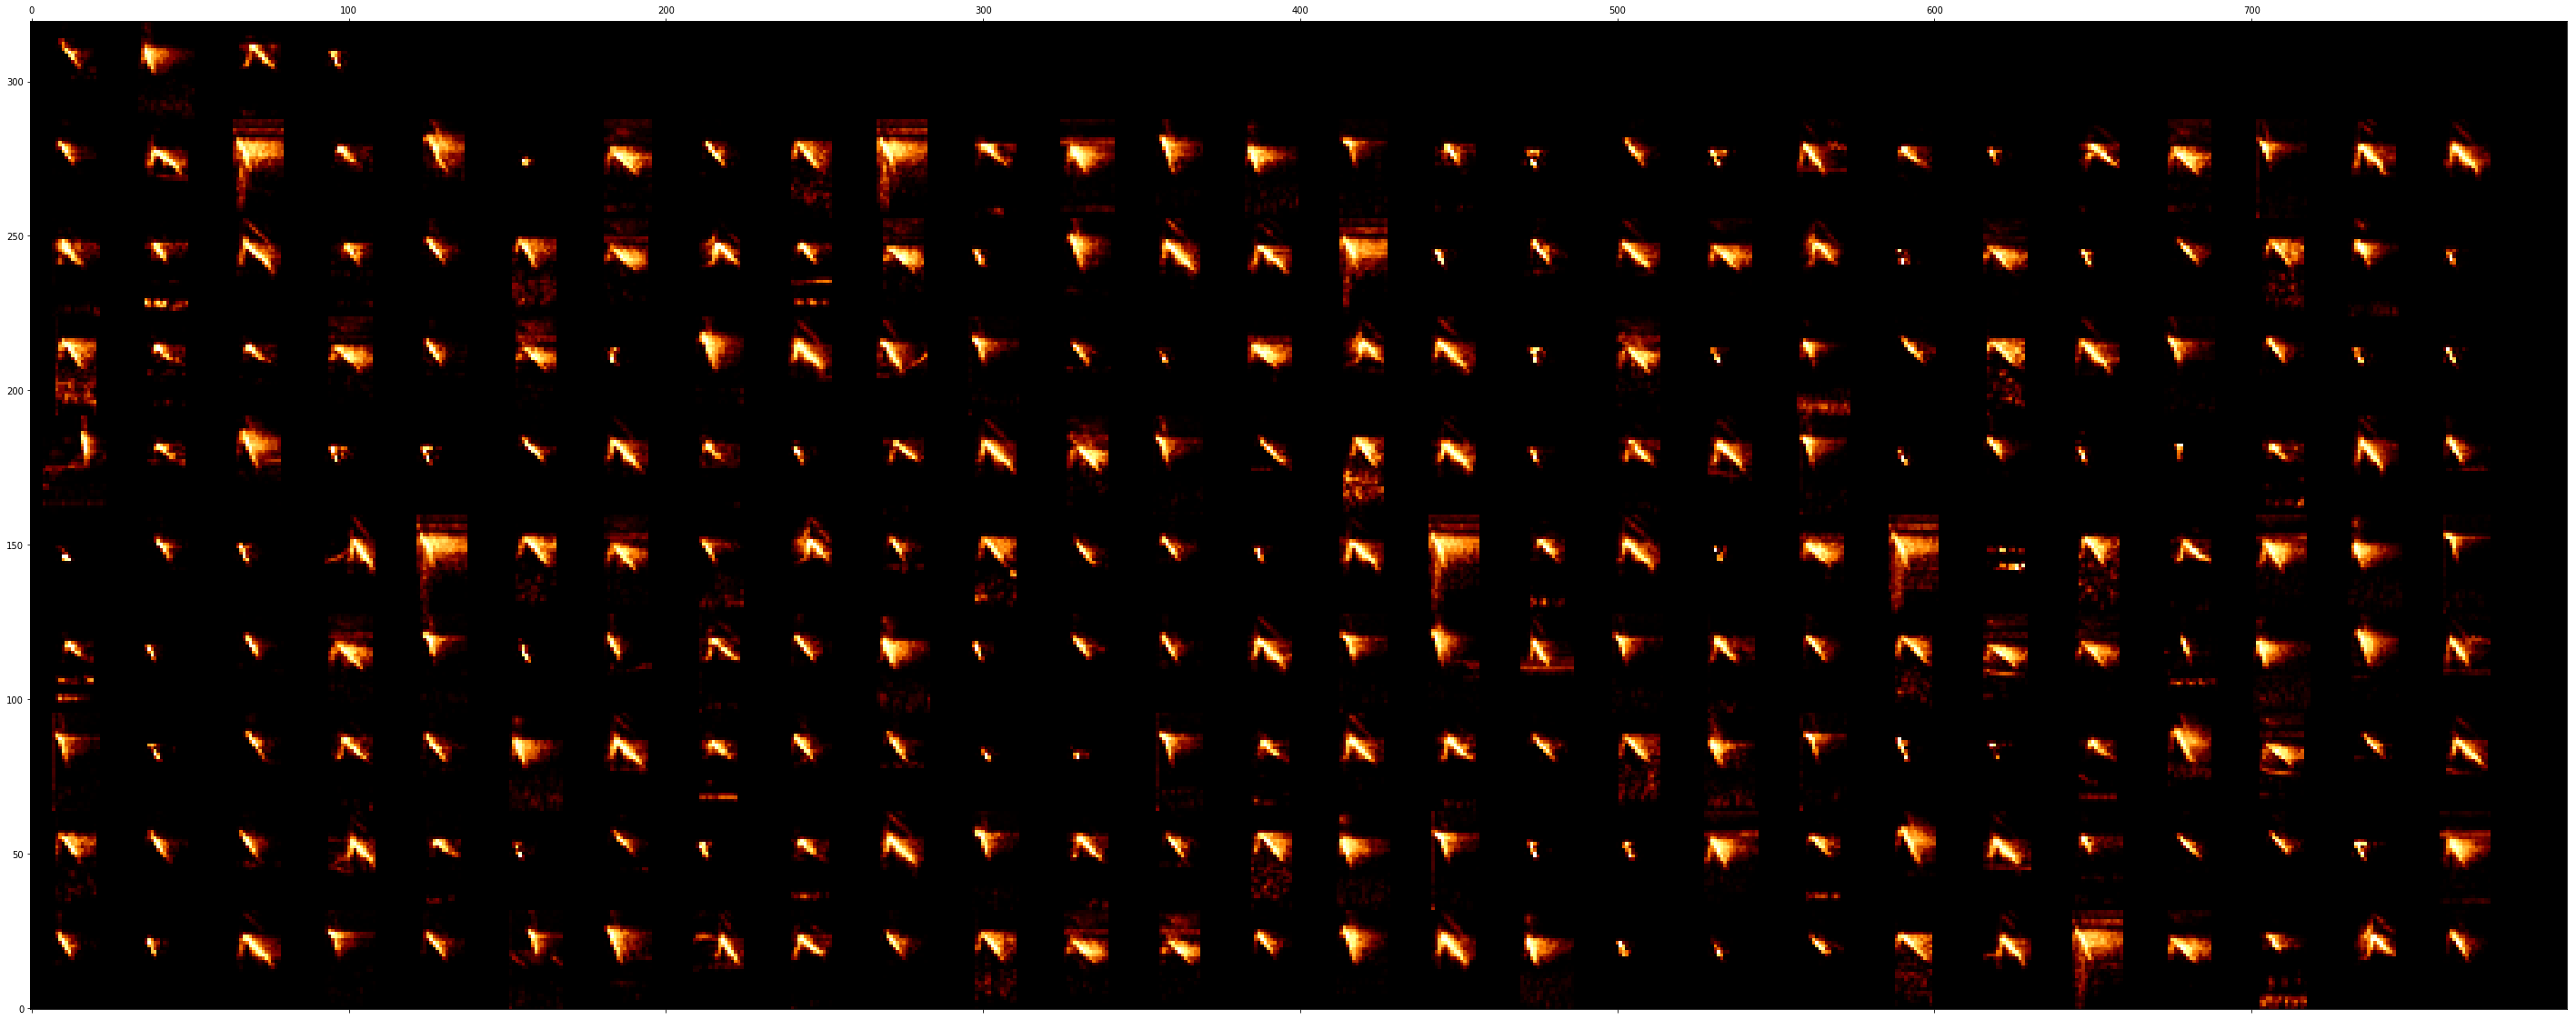

Blue jay 251
(50.0, 20) (320, 800) 25.0 32 800


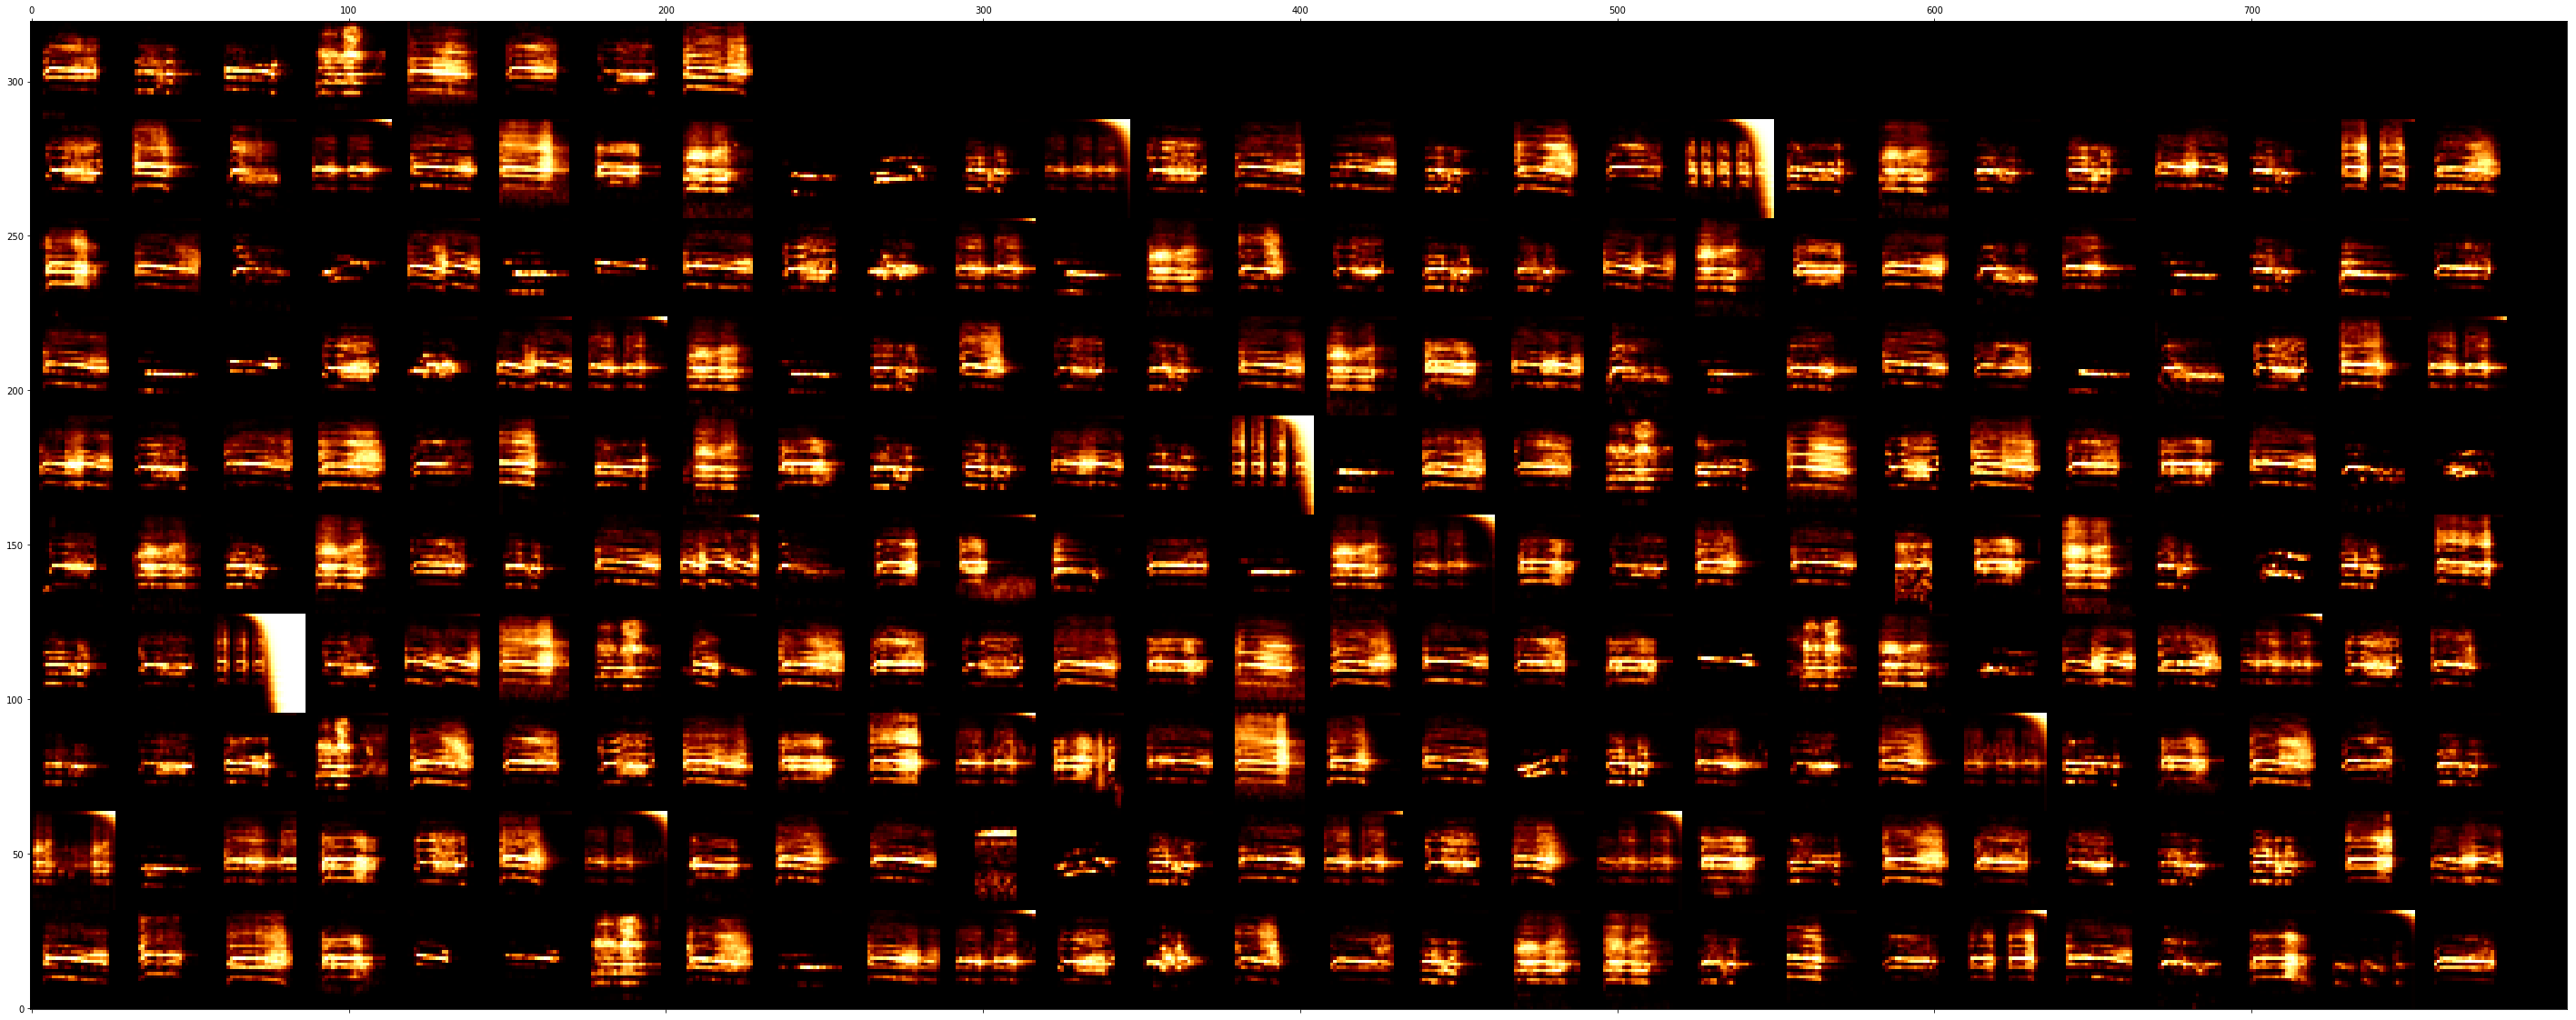

Cedar waxwing 246
(50.0, 20) (320, 800) 25.0 32 800


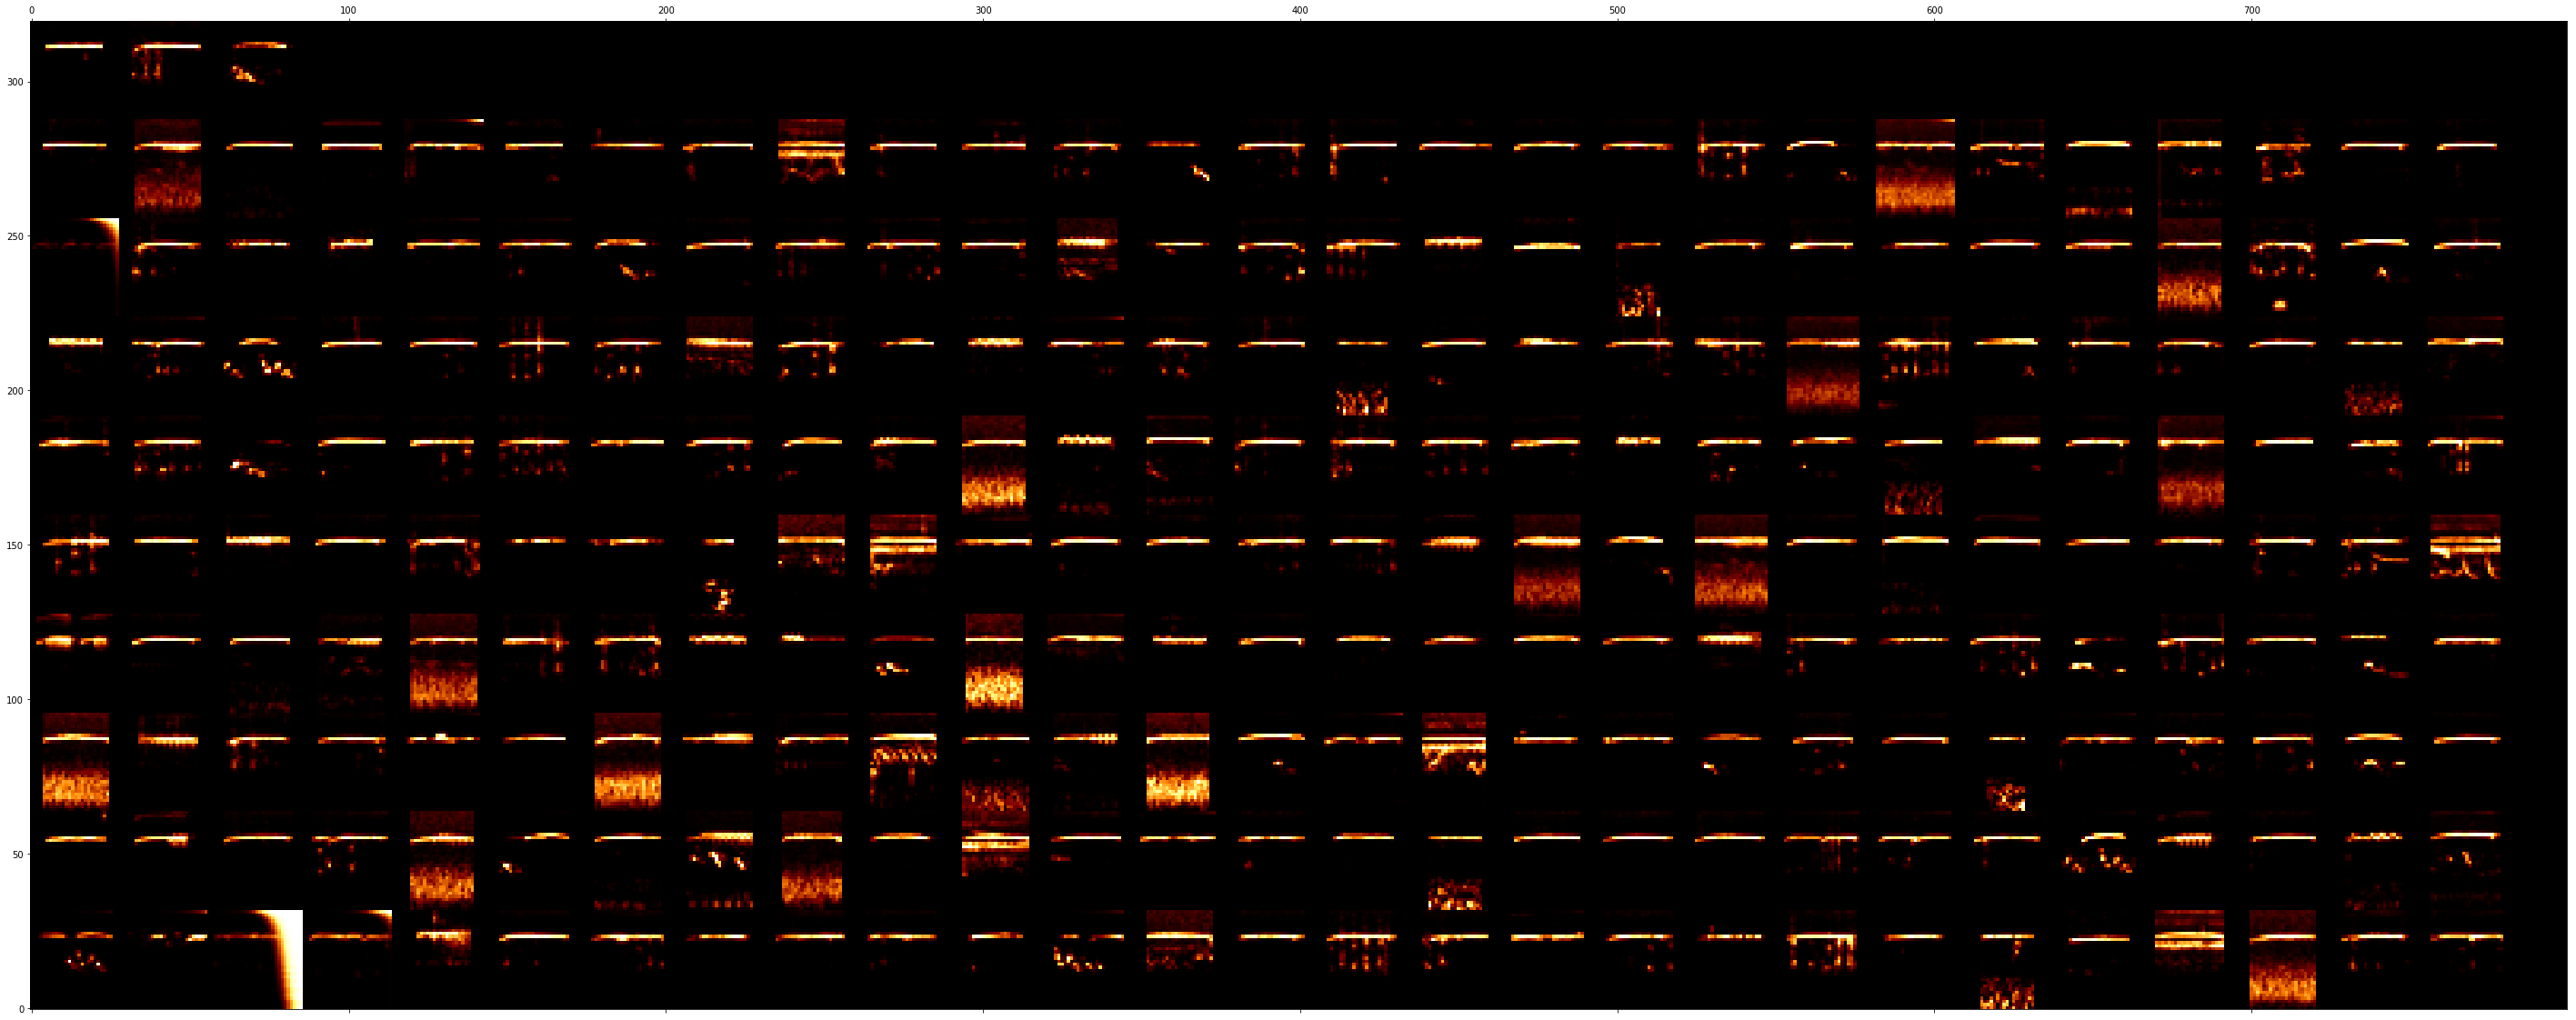

Chipping sparrow 253
(50.0, 20) (320, 800) 25.0 32 800


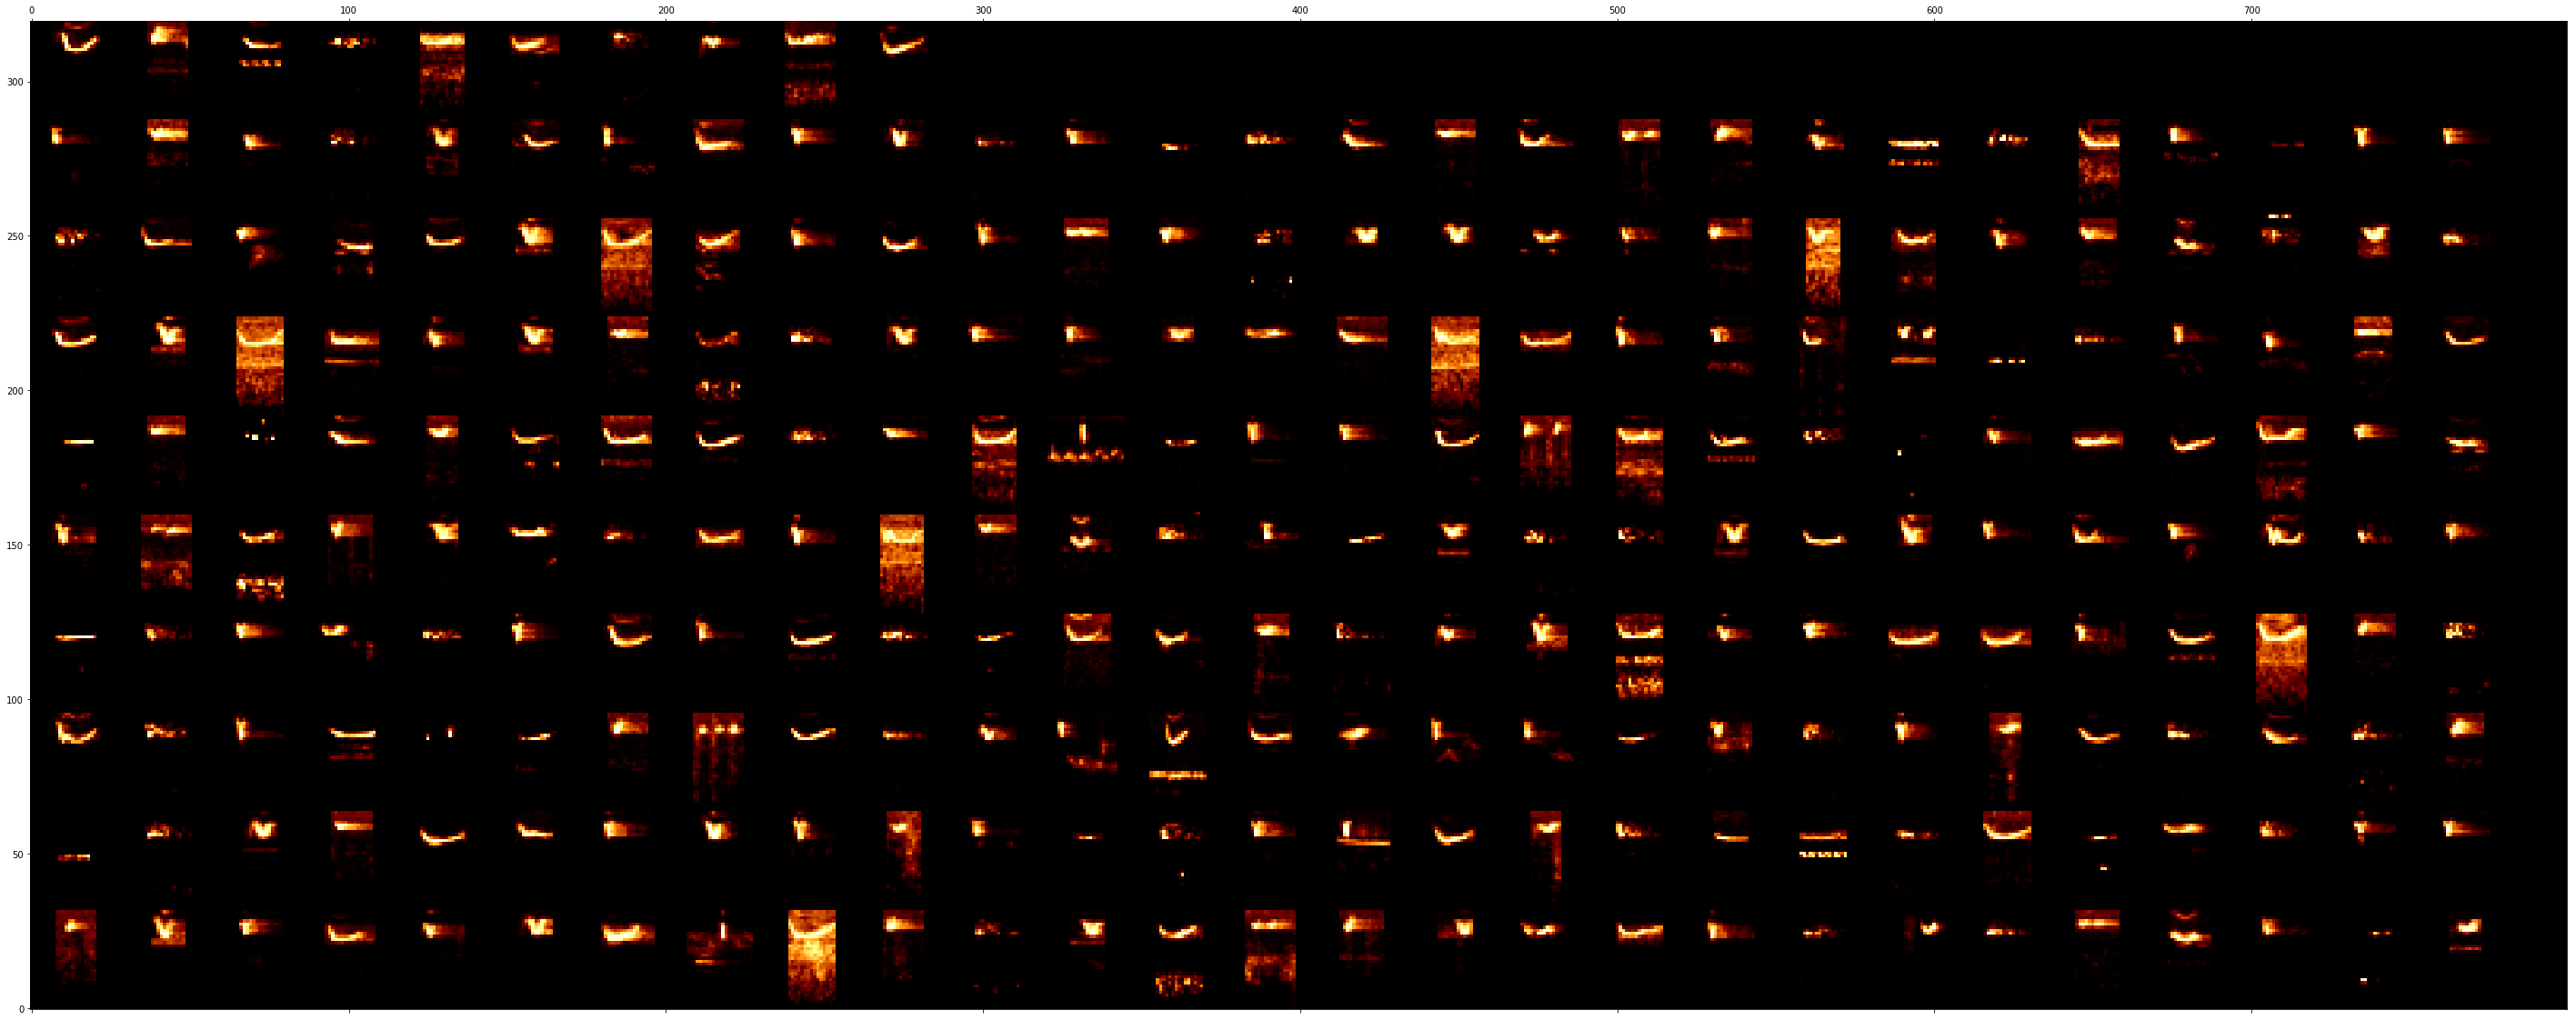

Common yellowthroat 256
(50.0, 20) (320, 800) 25.0 32 800


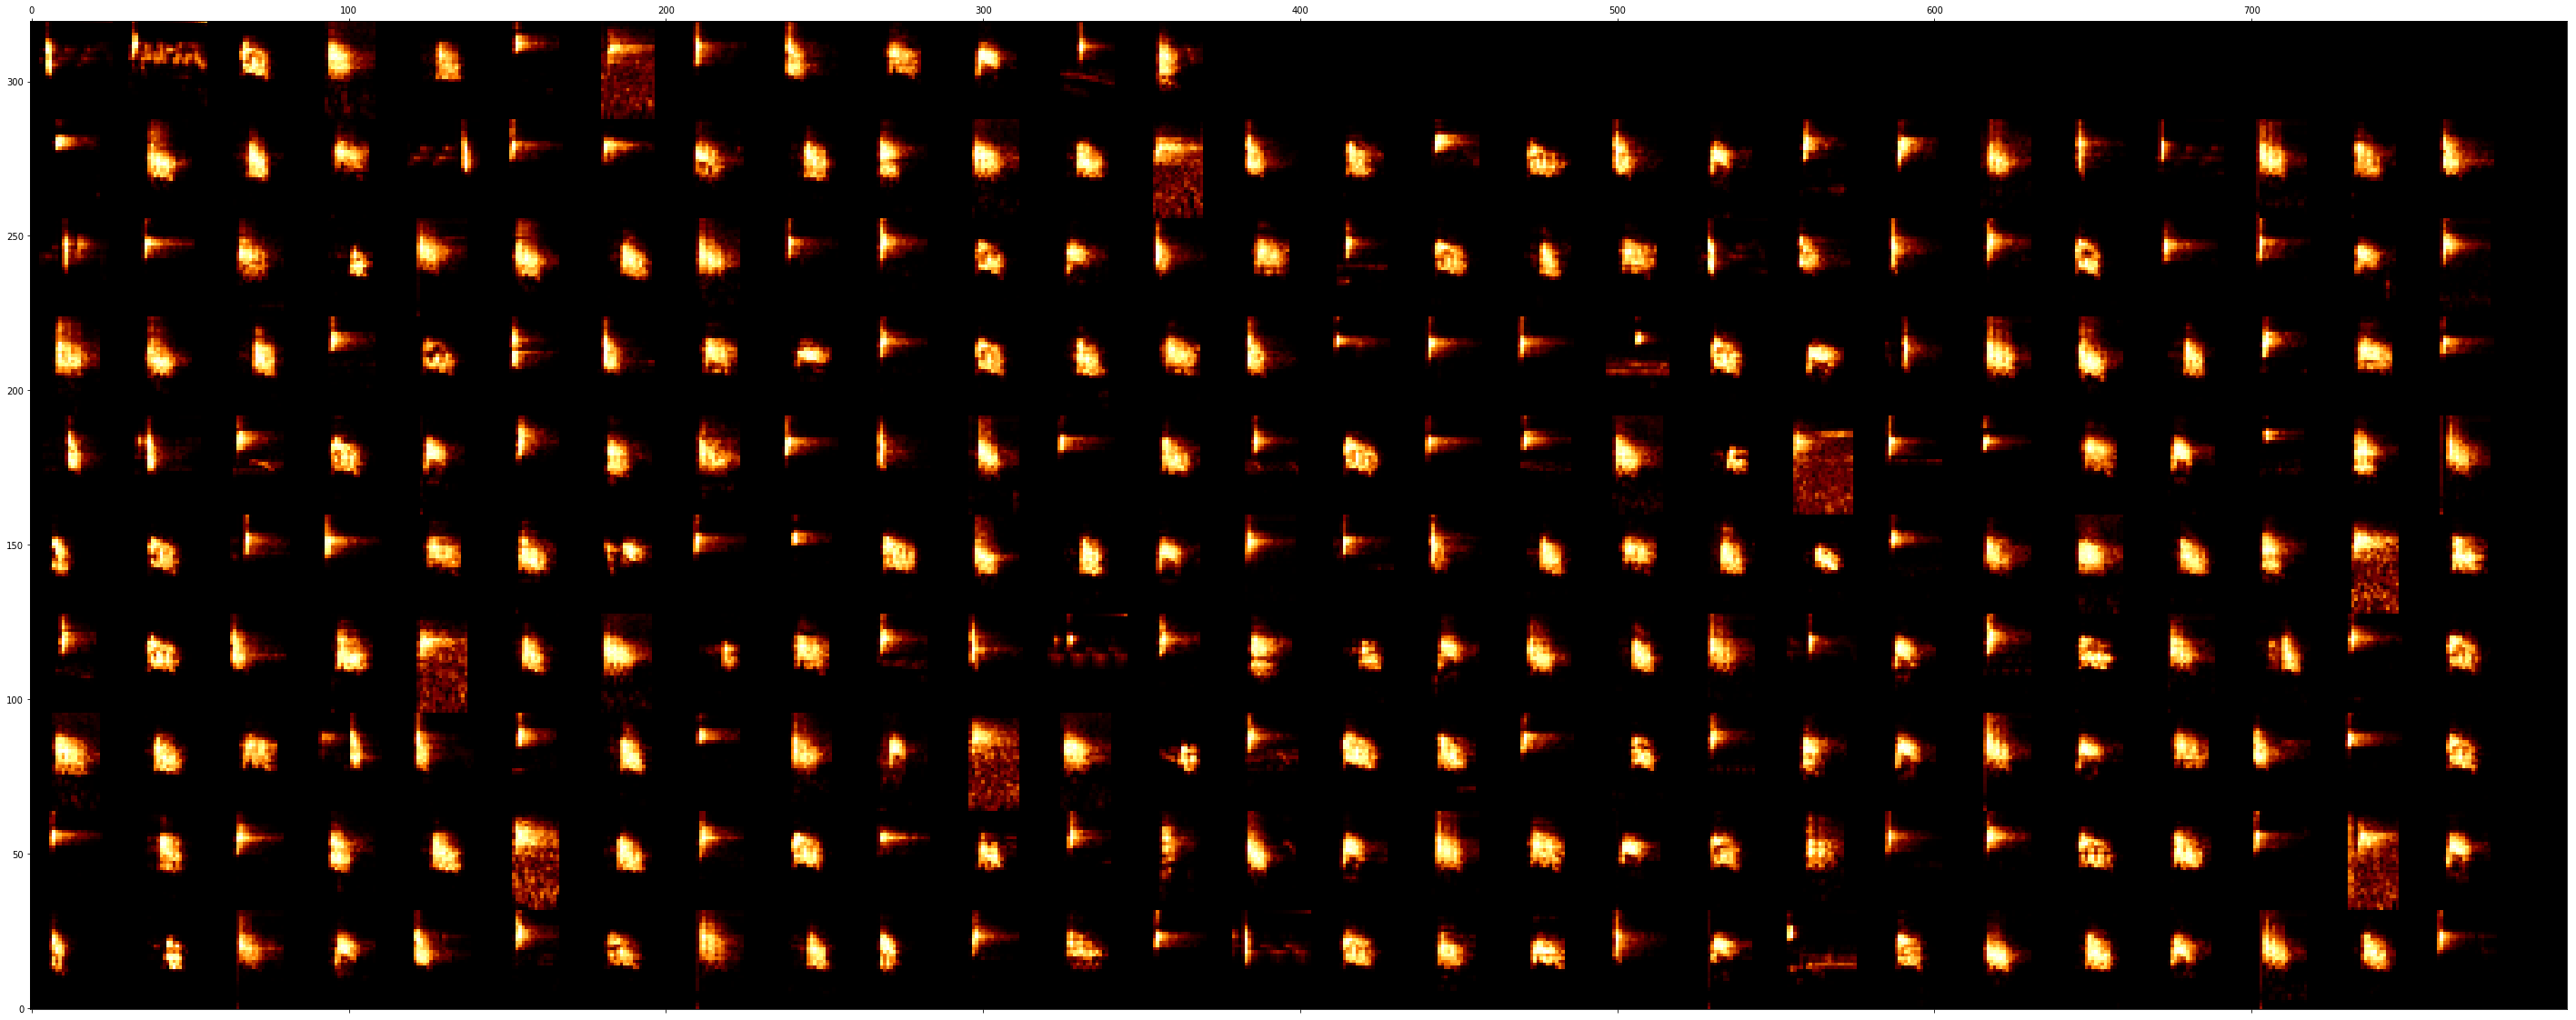

Great blue heron 247
(50.0, 20) (320, 800) 25.0 32 800


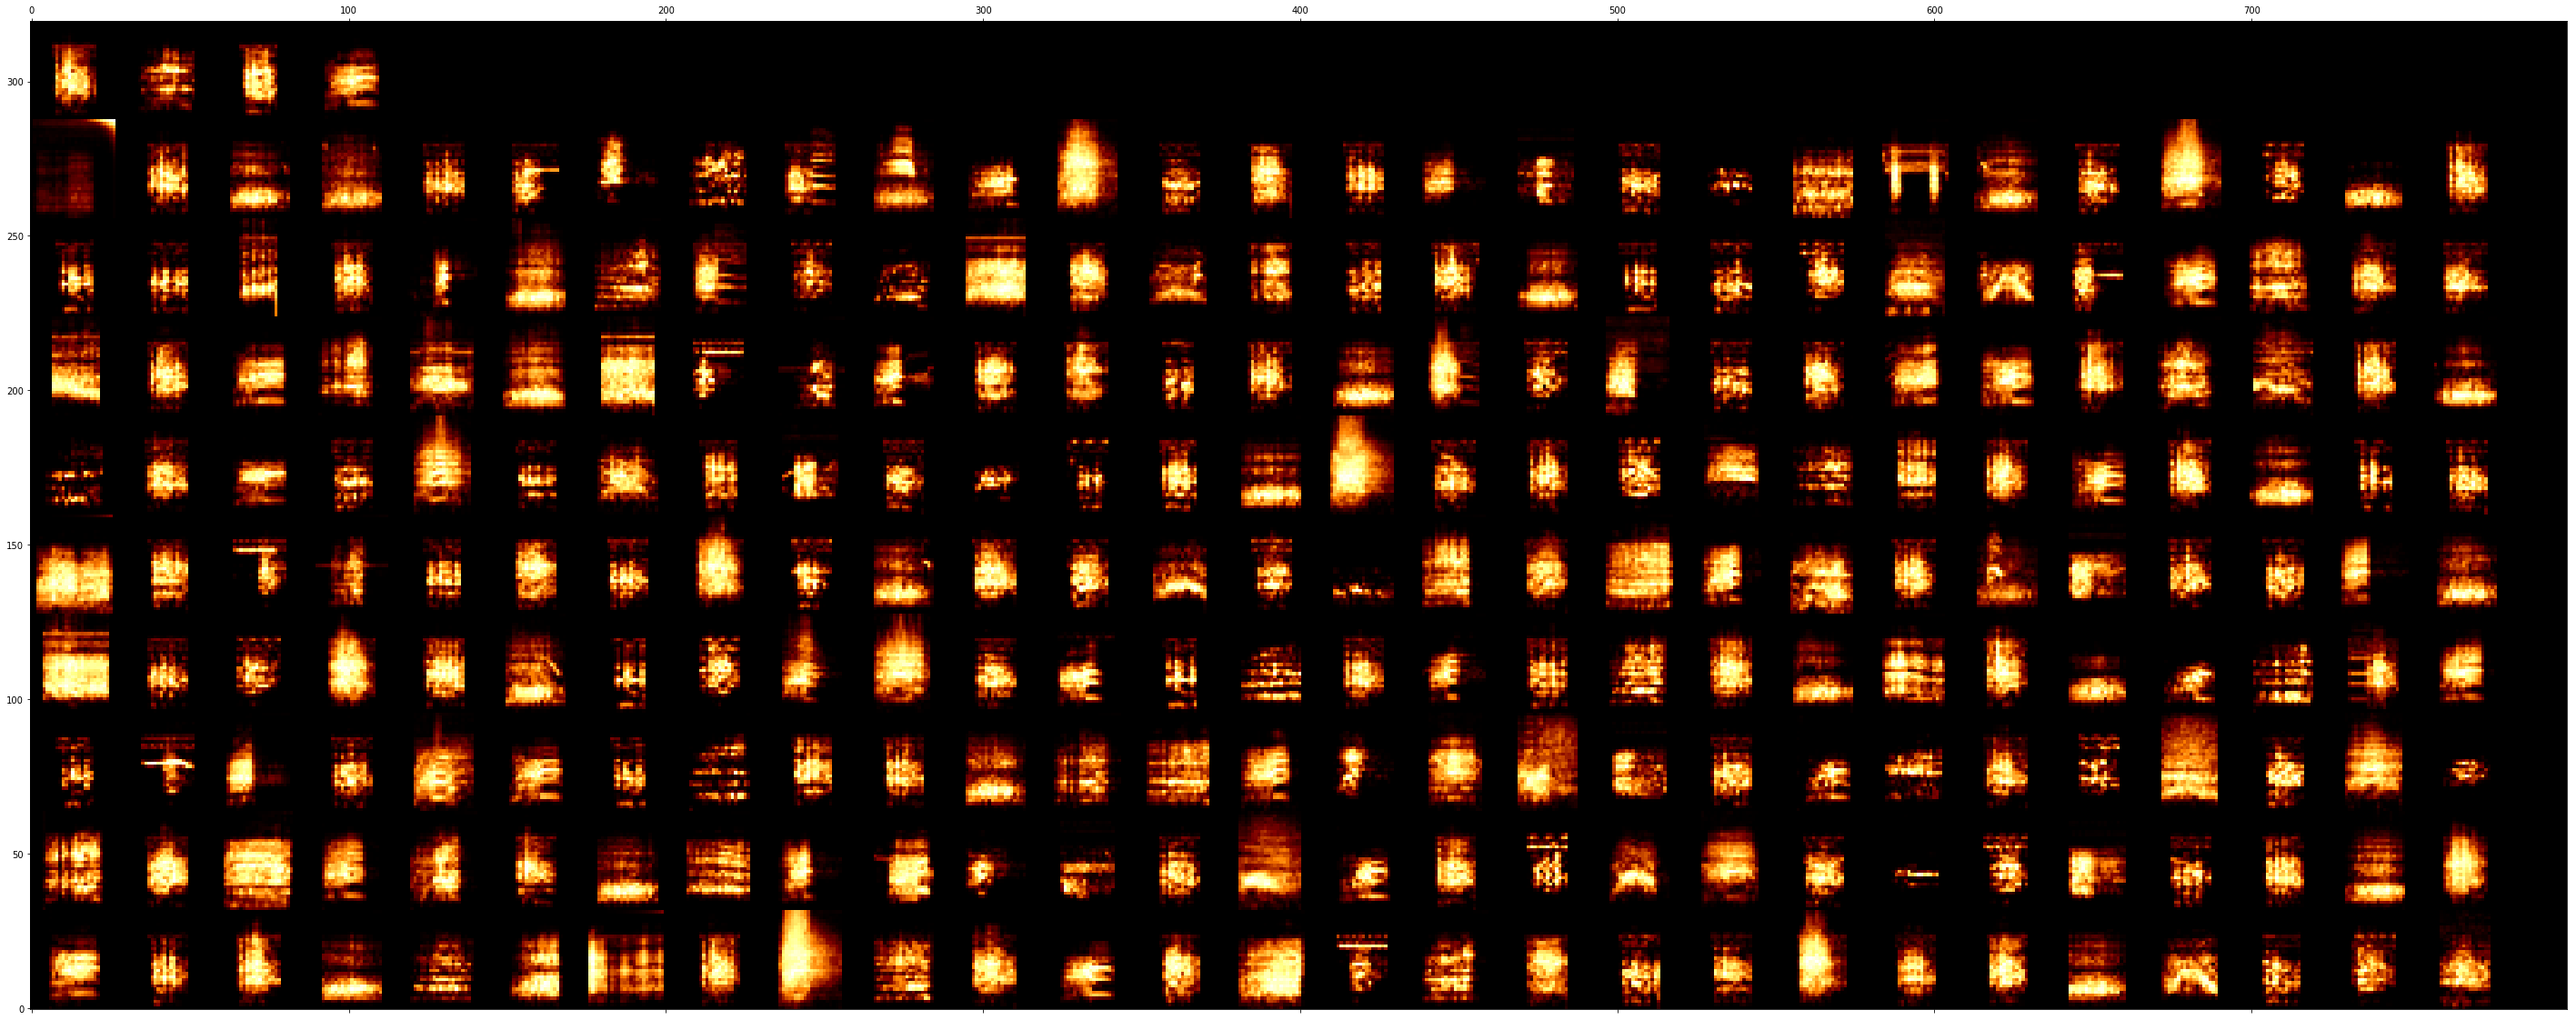

House finch 249
(50.0, 20) (320, 800) 25.0 32 800


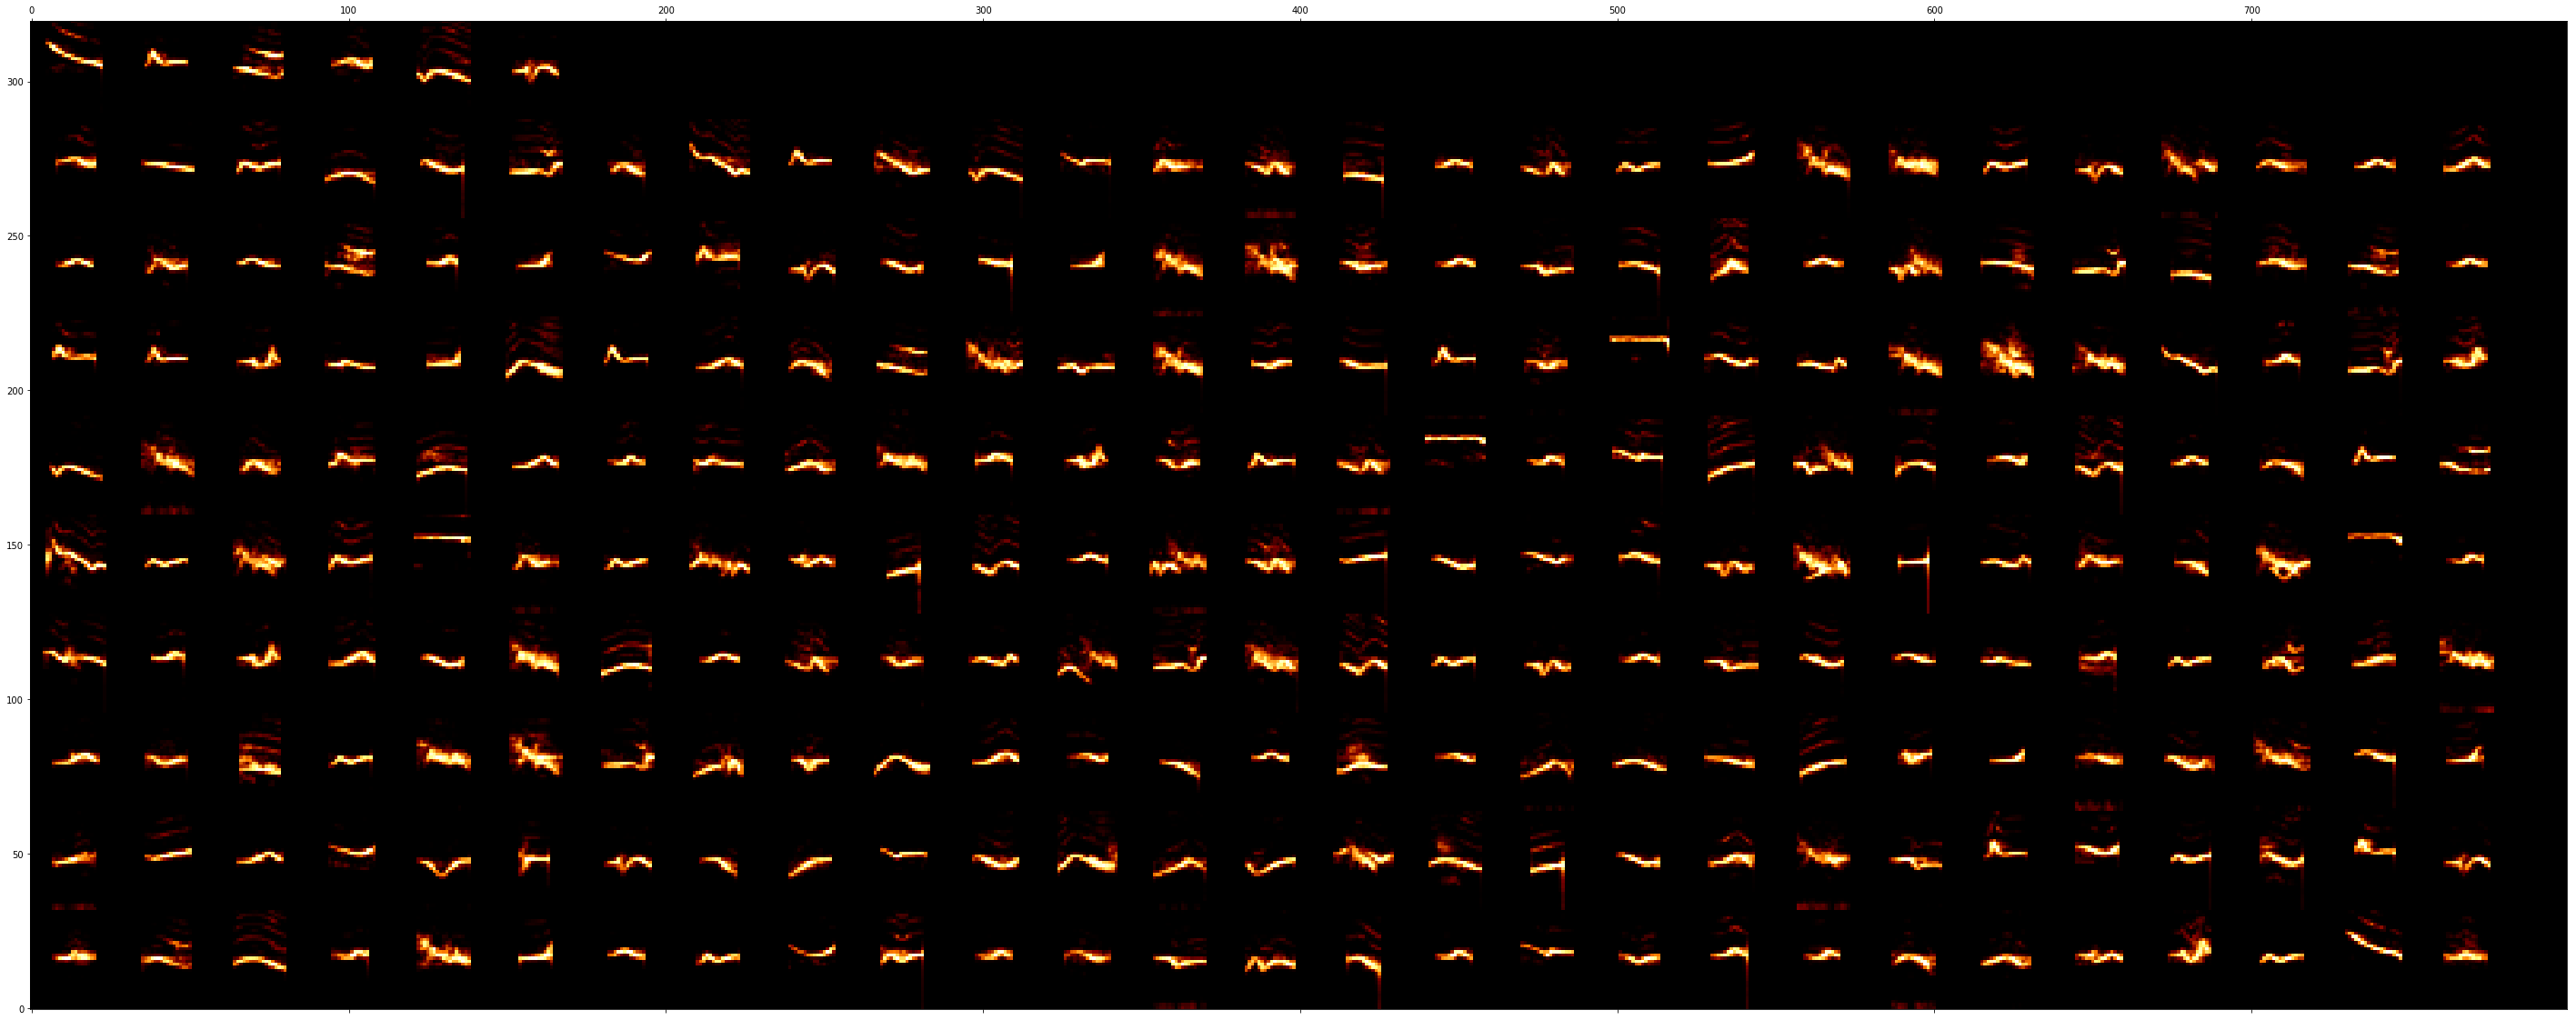

Indigo bunting 252
(50.0, 20) (320, 800) 25.0 32 800


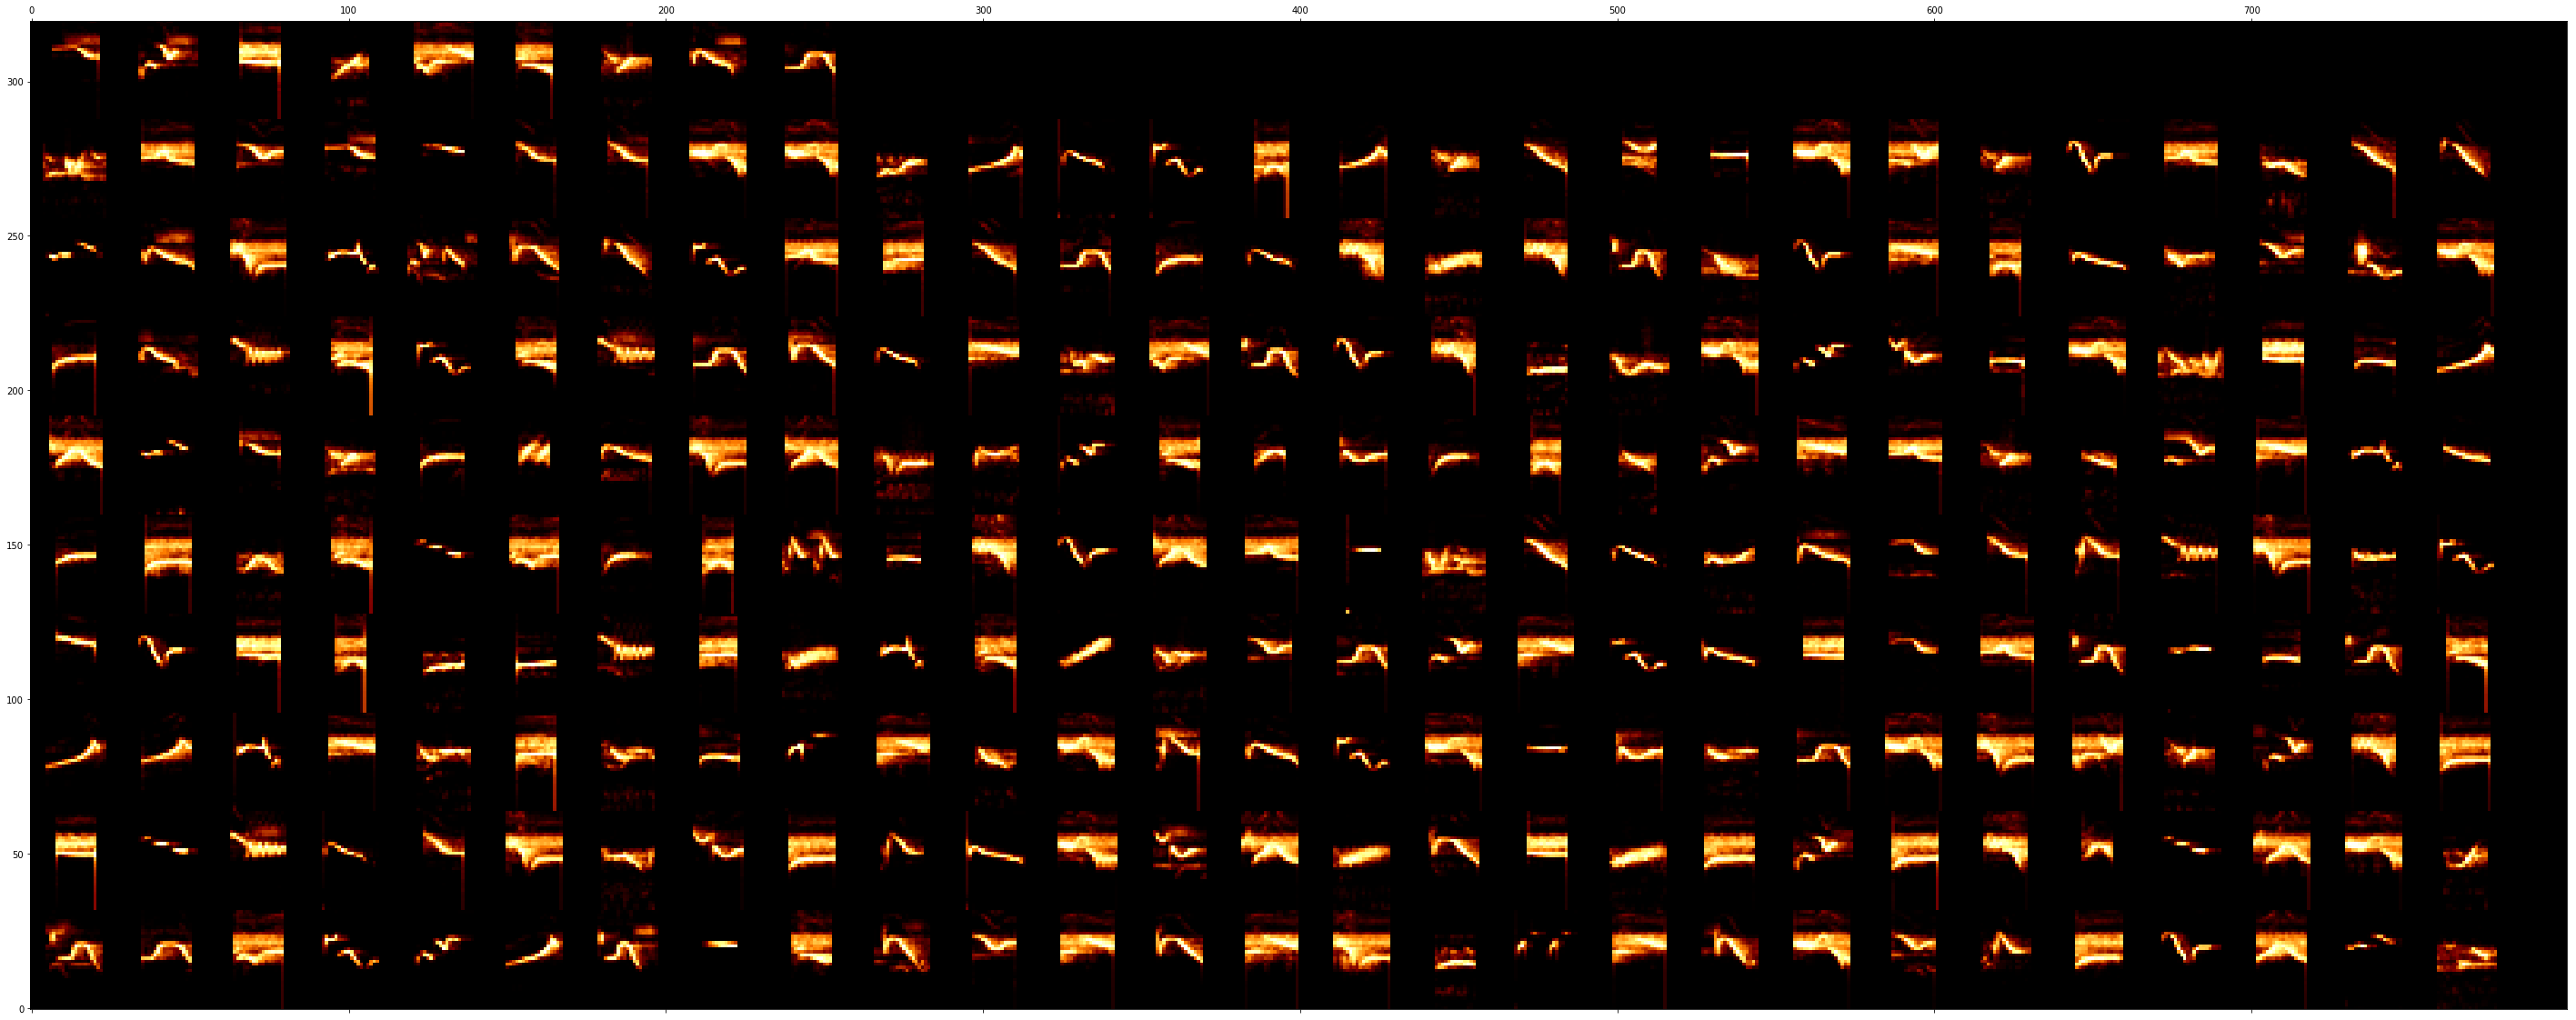

Marsh wren 249
(50.0, 20) (320, 800) 25.0 32 800


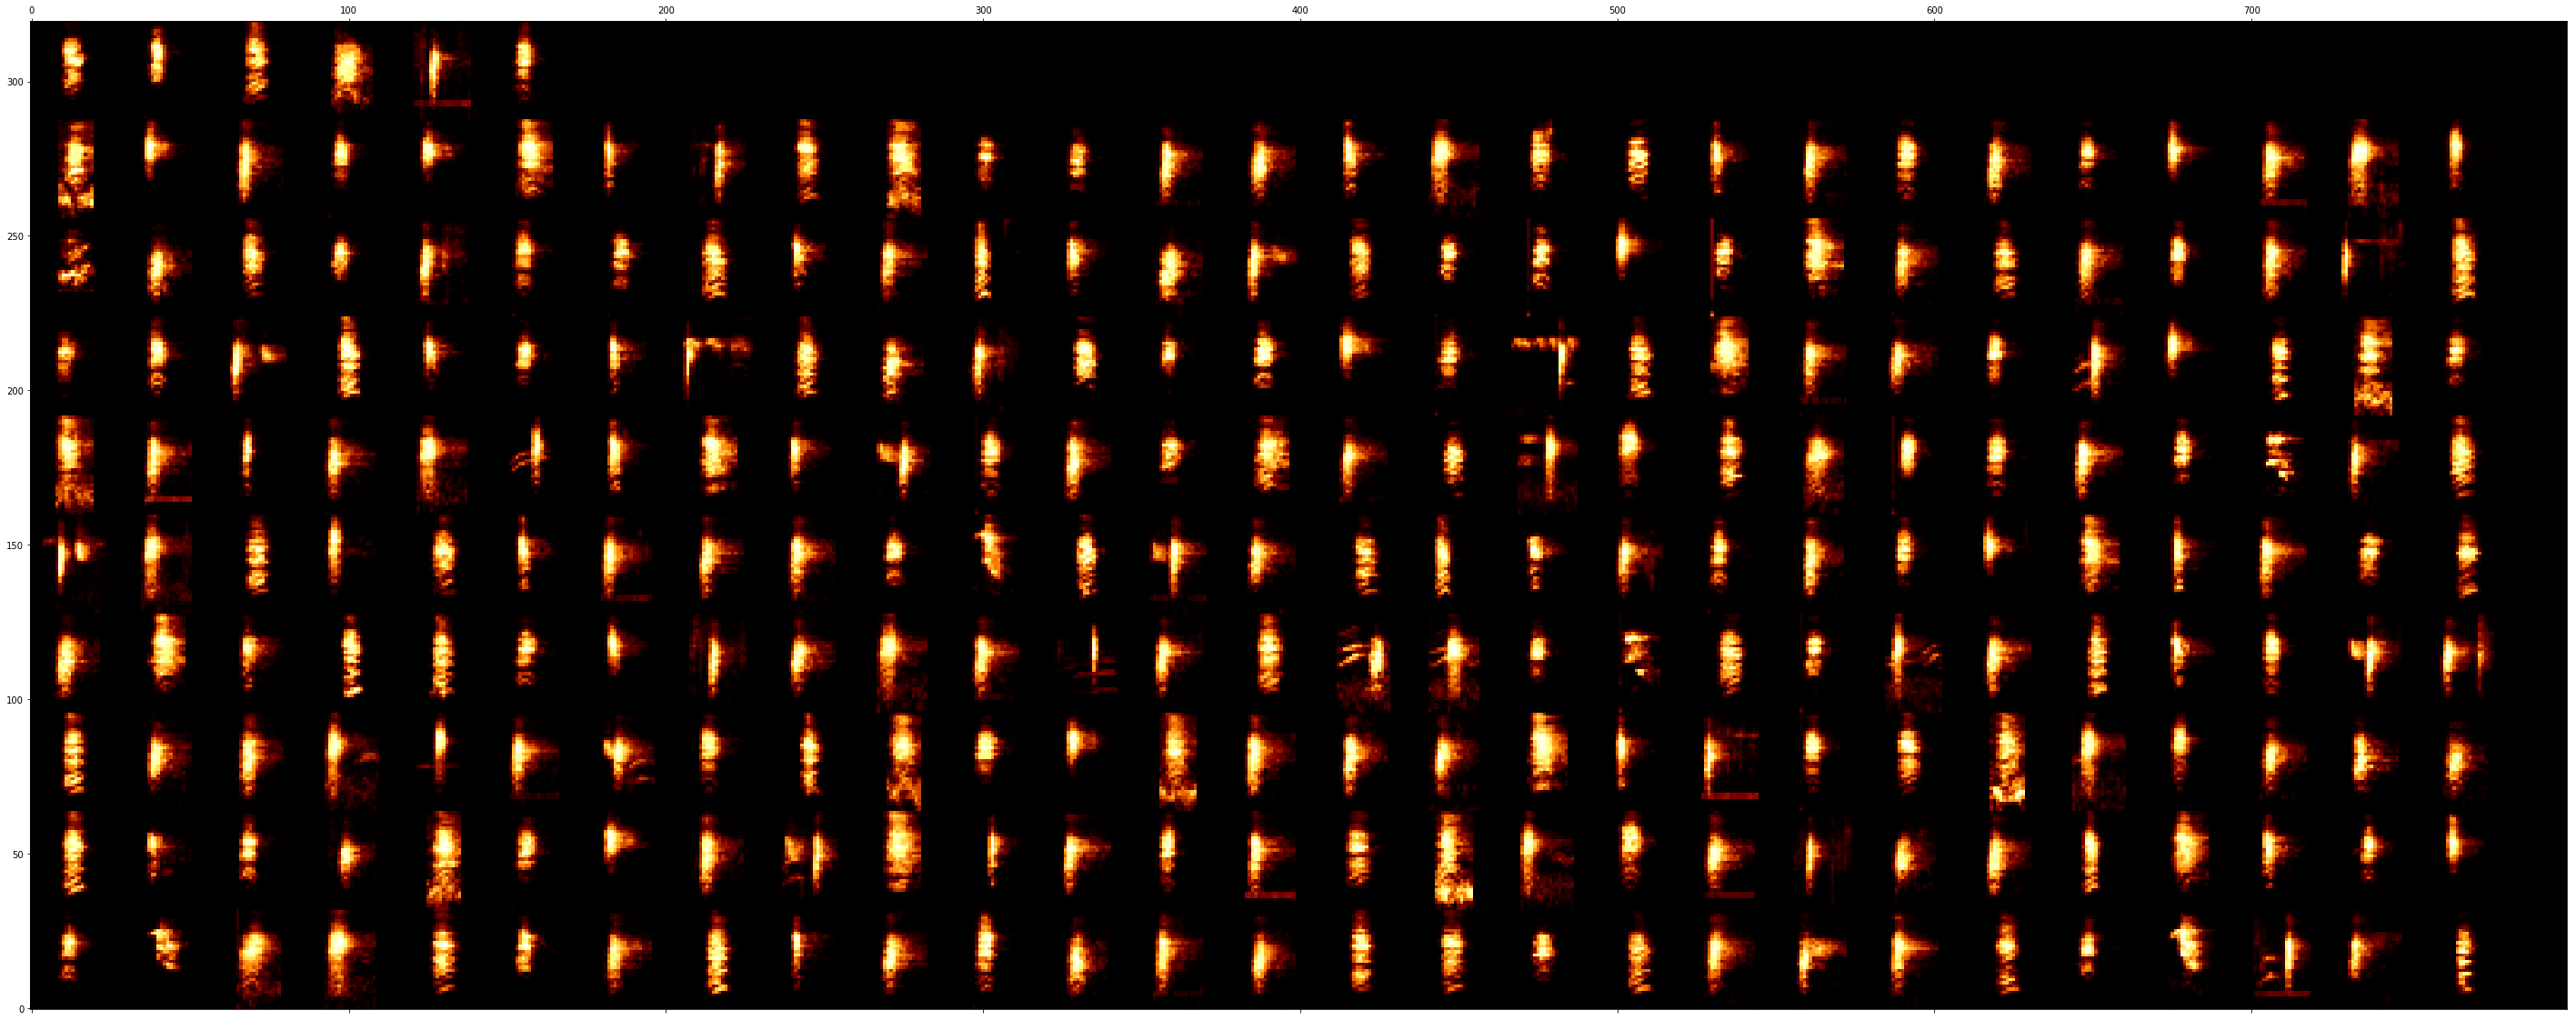

Song sparrow 259
(50.0, 20) (320, 800) 25.0 32 800


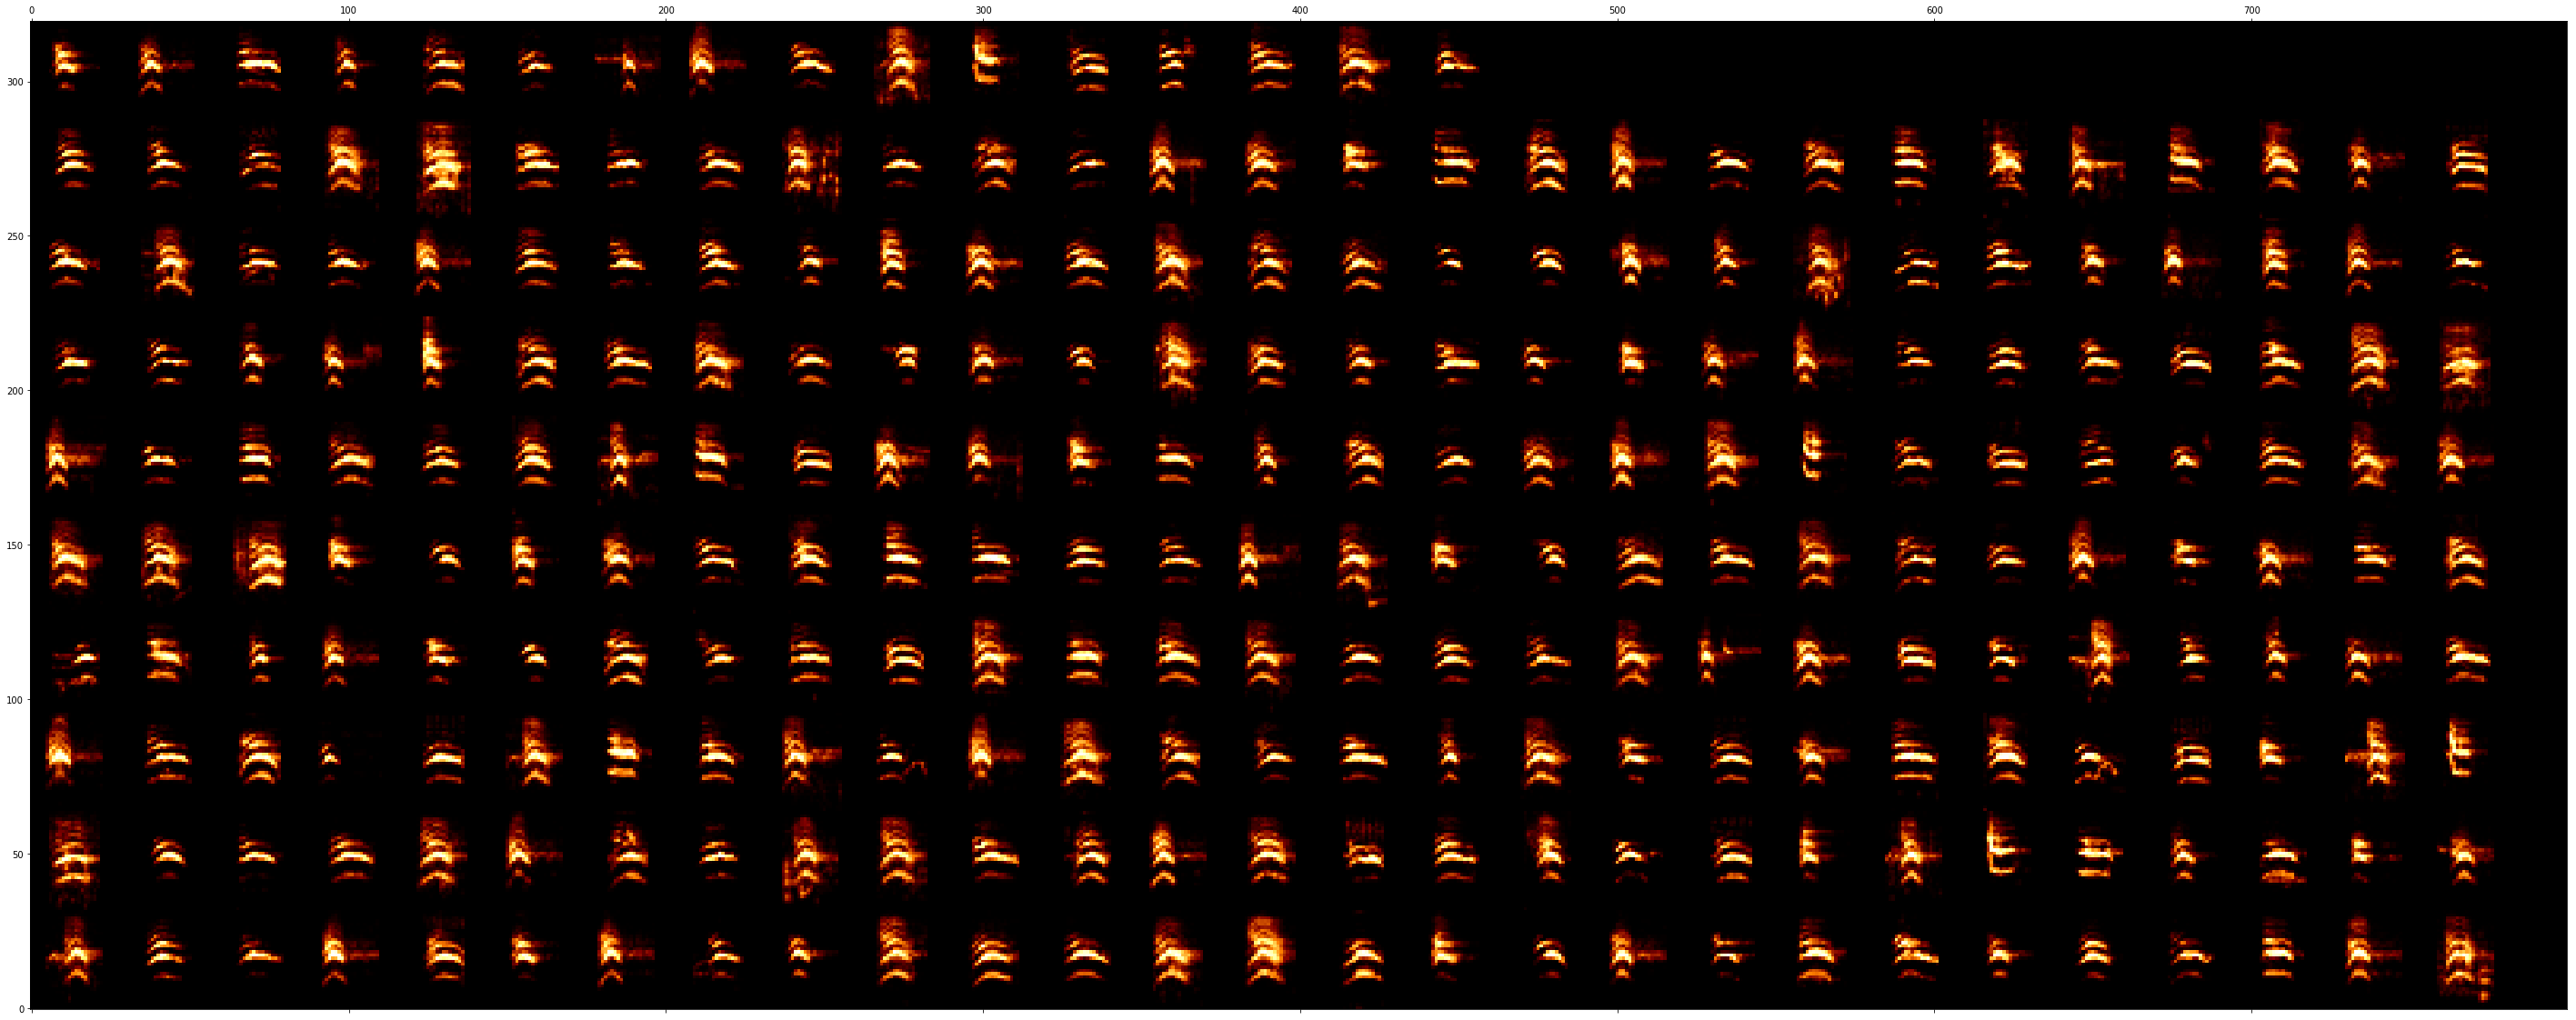

In [191]:
for species in np.sort(syllable_df.species.unique()):
    print(species, np.sum(syllable_df.species == species))
    specs = np.array([i/np.max(i) for i in syllable_df[syllable_df.species == species].spectrogram.values])
    specs[specs<0] = 0
    draw_spec_set(specs, zoom=2,
                  maxrows=16, 
                  colsize=25)

### save dataset

In [192]:
save_loc = DATA_DIR / 'syllable_dfs' / 'NA_BIRDS' / 'nabirds.pickle'
ensure_dir(save_loc)
syllable_df.to_pickle(save_loc)